In [1]:
!pip install torch torchvision torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 14.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.2MB/s]


In [5]:
class VGGNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [6]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(128 * 7 * 7, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [7]:
class SimpleResNet(nn.Module):
    def __init__(self, embedding_size=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(128 * 7 * 7, embedding_size)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return F.normalize(self.fc(x))

In [8]:
bce_loss = nn.BCEWithLogitsLoss()

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma * ce_loss).mean()

In [10]:
class ArcFaceLoss(nn.Module):
    def __init__(self, embedding_size=128, num_classes=10, margin=0.5, scale=30):
        super().__init__()
        self.W = nn.Parameter(torch.randn(num_classes, embedding_size))
        self.margin = margin
        self.scale = scale

    def forward(self, embeddings, labels):
        cosine = F.linear(embeddings, F.normalize(self.W))
        theta = torch.acos(torch.clamp(cosine, -1.0, 1.0))
        target_logits = torch.cos(theta + self.margin)
        one_hot = F.one_hot(labels, num_classes=10).float()
        logits = cosine * (1 - one_hot) + target_logits * one_hot
        return F.cross_entropy(logits * self.scale, labels)

In [15]:
!pip install tqdm

In [16]:
from tqdm import tqdm

In [17]:
def train(model, optimizer, loss_fn, epochs):
    model.to(device)
    train_acc, test_acc = [], []

    for epoch in range(epochs):
        model.train()
        correct = total = 0
        running_loss = 0.0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)

        for x, y in loop:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            outputs = model(x)

            if isinstance(loss_fn, nn.BCEWithLogitsLoss):
                y_onehot = F.one_hot(y, num_classes=10).float()
                loss = loss_fn(outputs, y_onehot)
            else:
                loss = loss_fn(outputs, y)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

            loop.set_postfix(
                loss=running_loss / (total / y.size(0)),
                acc=100. * correct / total
            )

        train_accuracy = correct / total
        train_acc.append(train_accuracy)

        # 🔍 Evaluation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                preds = outputs.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        test_accuracy = correct / total
        test_acc.append(test_accuracy)

        print(f"Epoch {epoch+1}/{epochs} → Train Acc: {train_accuracy:.4f} | Test Acc: {test_accuracy:.4f}")

    return train_acc, test_acc

In [18]:
model = VGGNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_acc_vgg, test_acc_vgg = train(
    model, optimizer, bce_loss, epochs=10
)

Epoch 1/10 → Train Acc: 0.9494 | Test Acc: 0.9857


Epoch 2/10 → Train Acc: 0.9884 | Test Acc: 0.9916


Epoch 3/10 → Train Acc: 0.9922 | Test Acc: 0.9903


Epoch 4/10 → Train Acc: 0.9938 | Test Acc: 0.9924


Epoch 5/10 → Train Acc: 0.9954 | Test Acc: 0.9924


Epoch 6/10 → Train Acc: 0.9960 | Test Acc: 0.9918


Epoch 7/10 → Train Acc: 0.9974 | Test Acc: 0.9936


Epoch 8/10 → Train Acc: 0.9981 | Test Acc: 0.9940


Epoch 9/10 → Train Acc: 0.9983 | Test Acc: 0.9936


Epoch 10/10 → Train Acc: 0.9987 | Test Acc: 0.9934


In [19]:
model = AlexNet()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
focal_loss = FocalLoss()

train_acc_alex, test_acc_alex = train(
    model, optimizer, focal_loss, epochs=20
)

Epoch 1/20 → Train Acc: 0.9575 | Test Acc: 0.9823


Epoch 2/20 → Train Acc: 0.9853 | Test Acc: 0.9876


Epoch 3/20 → Train Acc: 0.9880 | Test Acc: 0.9880


Epoch 4/20 → Train Acc: 0.9901 | Test Acc: 0.9878


Epoch 5/20 → Train Acc: 0.9925 | Test Acc: 0.9897


Epoch 6/20 → Train Acc: 0.9939 | Test Acc: 0.9901


Epoch 7/20 → Train Acc: 0.9949 | Test Acc: 0.9903


Epoch 8/20 → Train Acc: 0.9959 | Test Acc: 0.9912


Epoch 9/20 → Train Acc: 0.9970 | Test Acc: 0.9905


Epoch 10/20 → Train Acc: 0.9972 | Test Acc: 0.9905


Epoch 11/20 → Train Acc: 0.9982 | Test Acc: 0.9909


Epoch 12/20 → Train Acc: 0.9985 | Test Acc: 0.9916


Epoch 13/20 → Train Acc: 0.9989 | Test Acc: 0.9910


Epoch 14/20 → Train Acc: 0.9993 | Test Acc: 0.9898


Epoch 15/20 → Train Acc: 0.9994 | Test Acc: 0.9906


Epoch 16/20 → Train Acc: 0.9996 | Test Acc: 0.9908


Epoch 17/20 → Train Acc: 0.9999 | Test Acc: 0.9909


Epoch 18/20 → Train Acc: 0.9998 | Test Acc: 0.9907


Epoch 19/20 → Train Acc: 0.9999 | Test Acc: 0.9911


Epoch 20/20 → Train Acc: 1.0000 | Test Acc: 0.9904


In [21]:
def train_res(model, optimizer, loss_fn, epochs):
    model.to(device)
    train_acc, test_acc = [], []

    for epoch in range(epochs):
        model.train()
        correct = total = 0
        running_loss = 0.0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)

        for x, y in loop:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            outputs = model(x)

            # ✅ BCE case (one-hot)
            if isinstance(loss_fn, nn.BCEWithLogitsLoss):
                y_onehot = F.one_hot(y, num_classes=10).float()
                loss = loss_fn(outputs, y_onehot)

            # ✅ ArcFace case
            elif isinstance(loss_fn, ArcFaceLoss):
                loss = loss_fn(outputs, y)

            # ✅ Focal / CE case
            else:
                loss = loss_fn(outputs, y)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

            loop.set_postfix(
                loss=running_loss / (total / y.size(0)),
                acc=100. * correct / total
            )

        train_accuracy = correct / total
        train_acc.append(train_accuracy)

        # 🔍 Evaluation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                preds = outputs.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        test_accuracy = correct / total
        test_acc.append(test_accuracy)

        print(f"Epoch {epoch+1}/{epochs} → Train Acc: {train_accuracy:.4f} | Test Acc: {test_accuracy:.4f}")

    return train_acc, test_acc


In [22]:
model = SimpleResNet()
arcface_loss = ArcFaceLoss().to(device)

optimizer = optim.Adam(
    list(model.parameters()) + list(arcface_loss.parameters()),
    lr=0.001
)

train_acc_res, test_acc_res = train_res(
    model, optimizer, arcface_loss, epochs=15
)


Epoch 1/15 → Train Acc: 0.0277 | Test Acc: 0.0219


Epoch 2/15 → Train Acc: 0.0386 | Test Acc: 0.0271


Epoch 3/15 → Train Acc: 0.0400 | Test Acc: 0.0268


Epoch 4/15 → Train Acc: 0.0431 | Test Acc: 0.0527


Epoch 5/15 → Train Acc: 0.0379 | Test Acc: 0.0295


Epoch 6/15 → Train Acc: 0.0395 | Test Acc: 0.0507


Epoch 7/15 → Train Acc: 0.0349 | Test Acc: 0.0286


Epoch 8/15 → Train Acc: 0.0364 | Test Acc: 0.0285


Epoch 9/15 → Train Acc: 0.0309 | Test Acc: 0.0167


Epoch 10/15 → Train Acc: 0.0293 | Test Acc: 0.0272


Epoch 11/15 → Train Acc: 0.0300 | Test Acc: 0.0185


Epoch 12/15 → Train Acc: 0.0286 | Test Acc: 0.0381


Epoch 13/15 → Train Acc: 0.0266 | Test Acc: 0.0175


Epoch 14/15 → Train Acc: 0.0286 | Test Acc: 0.0264


Epoch 15/15 → Train Acc: 0.0305 | Test Acc: 0.0256


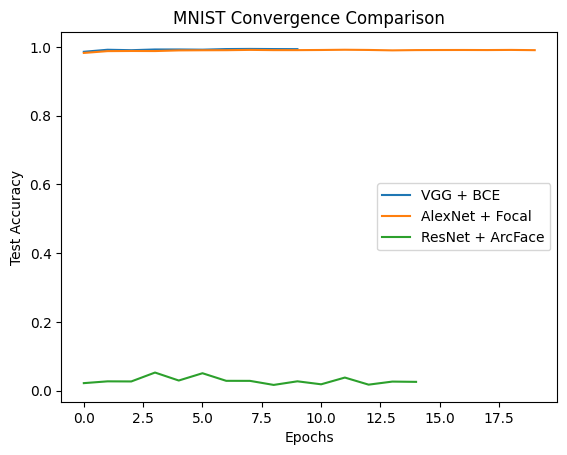

In [23]:
plt.plot(test_acc_vgg, label="VGG + BCE")
plt.plot(test_acc_alex, label="AlexNet + Focal")
plt.plot(test_acc_res, label="ResNet + ArcFace")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.legend()
plt.title("MNIST Convergence Comparison")
plt.show()